In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.linalg as sla
from sklearn.cluster import KMeans


In [28]:
def get_zero_block(N,M):
    return pd.DataFrame(np.ndarray((M,N), buffer =np.zeros(M*N)))

def build_matrix(A1,A2,A3):
    A1 = np.append(A1,A2, axis=1)
    A2 = np.append(A2.transpose(), A3, axis=1)
    return pd.DataFrame(np.append(A1,A2, axis=0))

def perturb_matrix(A, pf): 
    M,N = A.shape
    A1 = pd.DataFrame(np.ndarray((M,M), buffer = np.random.rand(M*N)))
    P = (A1 * pf)
    P = P - np.diag(np.diag(P))
    return (A + P)

def generate_laplacian(C):
    L = (C - C.min().min()).values
    L= (L - np.diag(np.diag(L)))
    return (L - np.diag(sum(L.T)))

def visualize_spectrum(A, n_blocks, selection):
    (eigvals, eigvecs)=sla.eig(A)
    eigvals = pd.Series(eigvals)
    eigvals.sort_values(ascending=False, inplace=True)
    perm =  eigvals.index
    eigvecs = pd.DataFrame(eigvecs).iloc[:,perm]

    plt.figure()
    plt.title("dominant eigenvectors")
    for i in range(n_blocks):
        constvec = pd.Series(eigvecs.iloc[:,i])
        plt.plot(eigvecs.iloc[:,i])
        plt.hold
    
    plt.figure()
    M = A.shape[0]
    plt.plot(eigvals.values, '.', markerSize = 10)
    plt.title("eigenvalues")

    fig = plt.figure()
    plt.plot(eigvecs.iloc[:,selection[0]],eigvecs.iloc[:,selection[1]], 'd', markerSize = 10)
    plt.title("Components of eigenvectors {}".format(selection))
    plt.xlabel("eigenvector {}".format(selection[0]))
    plt.ylabel("eigenvector {}".format(selection[1]))
    ax = fig.gca()
    c = eigvecs.iloc[:,selection].abs().max().max()*1.5
    ax.set_xbound(-c,c)
    ax.set_ybound(-c,c)
    
    return eigvals,eigvecs


In [29]:
k  = 5
m  = 3
n  = 4

a1 = np.random.rand(m,m)
a2 = get_zero_block(n,m)
a3 = np.random.rand(n,n)

a1 = build_matrix(a1,a2,a3)
l  = a1.shape[0]
a2 = get_zero_block(k,l)
a3 = np.random.rand(k,k)

a = build_matrix(a1,a2,a3)
a = a - np.diag(np.diag(a)) + np.eye(len(a))
a = 0.5 * (a + a.T)

### visualisation of off-block entries

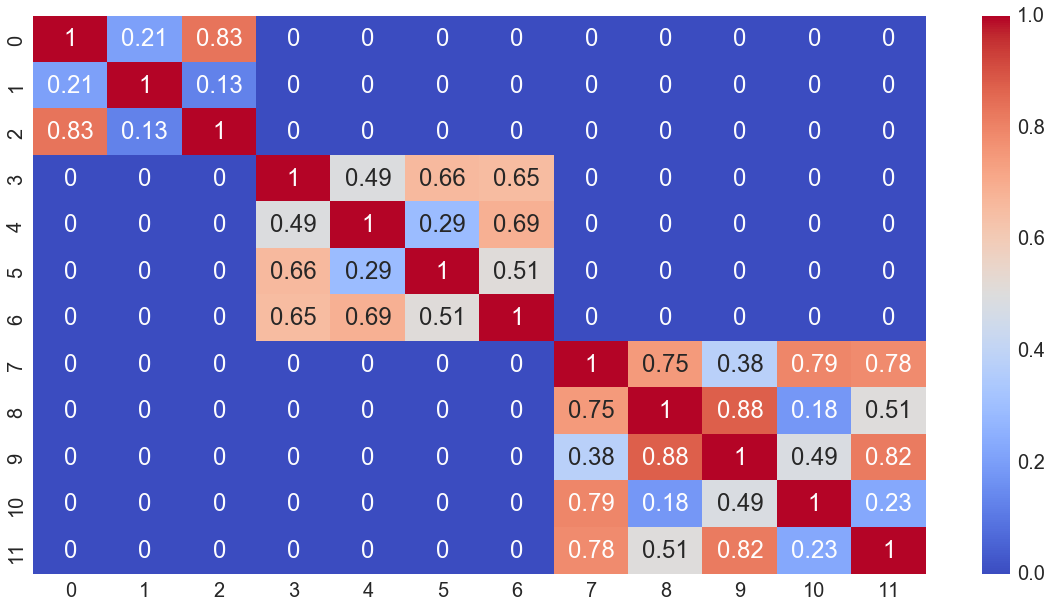

In [31]:
fig = plt.figure(figsize=(20,10))
sns.set(font_scale=2)
sns.heatmap(a, annot=True, cmap="coolwarm")


### Graph Laplacian of Similarity Matrix

We transform now the matrix $A$ to a Laplacian matrix. For each Block $B$ holds:
$$ B_{ii} = - \sum_{i \neq j} B_{ij} $$
$$ B_{ij} \geq 0 \forall i \neq j$$
For the eigenvalues $\lambda$ of a $N \times N $ matrix with these properties holds:
$$ 0 = \lambda_0 \geq \lambda_1 \geq ... \geq \lambda_N $$

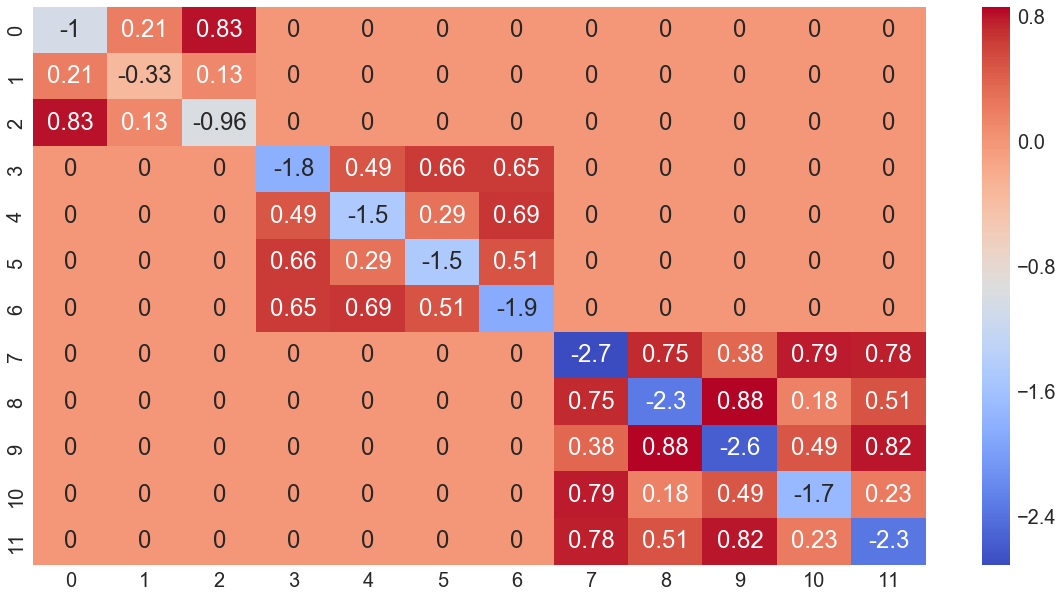

In [32]:
fig = plt.figure(figsize=(20,10))
l = pd.DataFrame(generate_laplacian(a))
sns.set(font_scale=2)
sns.heatmap(l, annot=True, cmap="coolwarm")


### Spectrum

Dominant Eigenvectors are piecewise constant, the largest Eigenvalue $0$ has a multplicity of three, which is the number of blocks.

/Users/evelyn.trautmann/anaconda/lib/python3.5/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


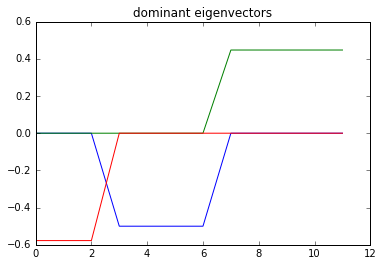

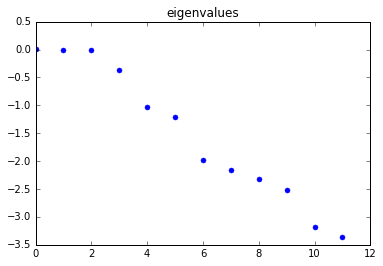

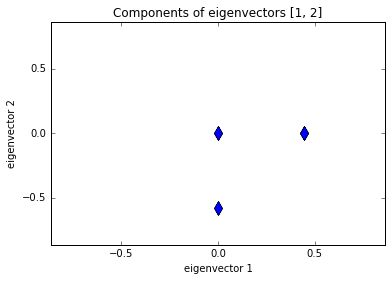

In [10]:
_ = visualize_spectrum(l, n_blocks=3, selection=[1,2])

### Perturbation

In [12]:
a_pert = perturb_matrix(a, 5e-2)

Now we take a perturbed block matrix into investigation. The dominant eigenvalues are almost piecewise constant and the second and third largest eigenvalues are close to $0$. 

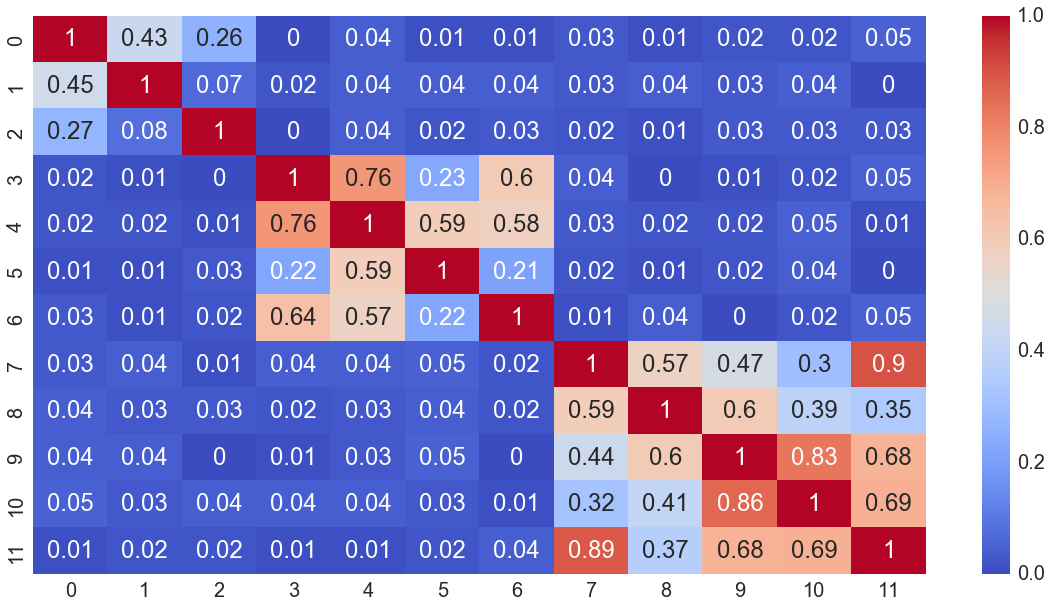

In [35]:
plt.figure(figsize=(20,10))
sns.heatmap(a_pert.round(2),annot=True, cmap="coolwarm")

/Users/evelyn.trautmann/anaconda/lib/python3.5/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


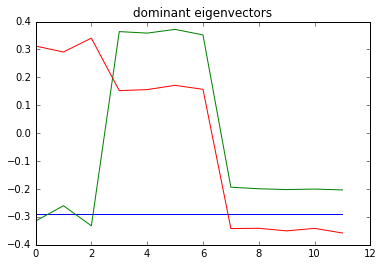

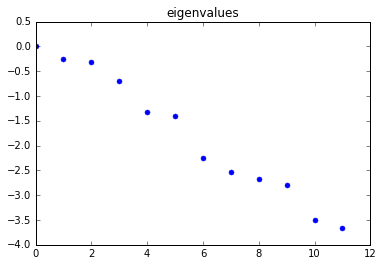

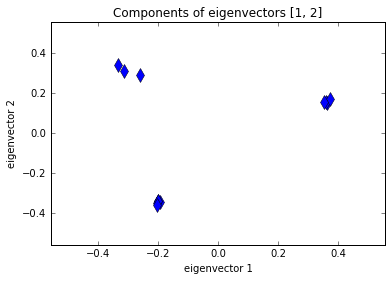

In [14]:
l_pert = generate_laplacian(a_pert)
eigvals,eigvecs = visualize_spectrum(l_pert, n_blocks=3, selection=[1,2])


### Permutation of A

In [20]:
perm = list(np.random.permutation(12))
a_pert_shuffled = a_pert.iloc[perm,perm]

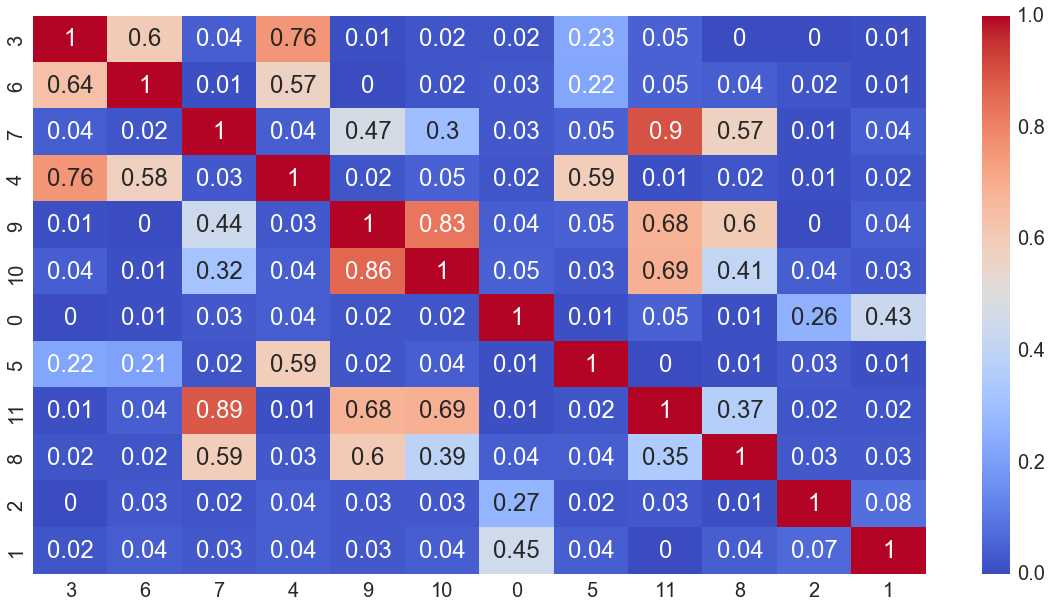

In [37]:
plt.figure(figsize=(20,10))
sns.heatmap(a_pert_shuffled.round(2), annot=True, cmap="coolwarm") 

After permutation A has lost its block structure. Eigenvalues and Eigenvectors are invariant under permutation but its entries are permuted as well.

/Users/evelyn.trautmann/anaconda/lib/python3.5/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


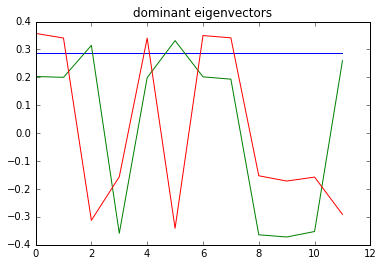

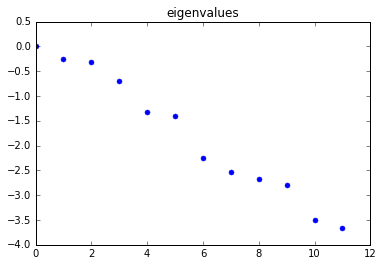

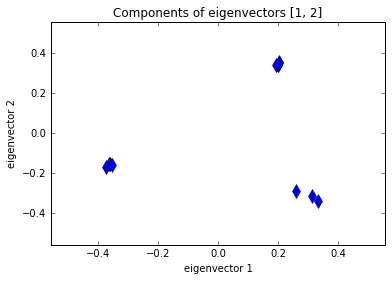

In [17]:
l_pert_shuffled = generate_laplacian(a_pert_shuffled)
eivals, eigvecs = visualize_spectrum(l_pert_shuffled, n_blocks=3, selection=[1,2])

### Spectral clustering

Take the eigenvectors of the dominant eigenvalues and cluster their entries. The resulting clusters correspond to the (perturbed) blocks of the initial matrix.

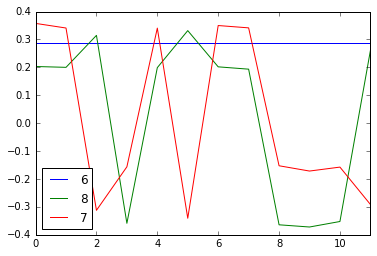

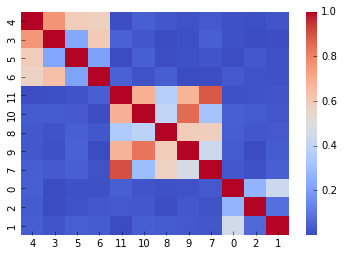

In [19]:
# take dominant eigenvectors as cluster_data  
cluster_data = pd.DataFrame(eigvecs).iloc[:,:3]
cluster_data.plot()
plt.figure()
# cluster with k-means 
res = KMeans(n_clusters=3).fit_predict(cluster_data)

# determine cluster assignment for each entry of eigenvector
df = pd.DataFrame({'assignment':res}, index=a_pert_shuffled.index)

# sort matrix according to cluster assignment
perm_inv = df.assignment.sort_values().index
result = a_pert_shuffled.loc[perm_inv, perm_inv] 

# retrieve block structure
sns.heatmap(result, cmap="coolwarm")

